In [80]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score
color_pal=sns.color_palette()
plt.style.use('fivethirtyeight')
import joblib

In [81]:
df = pd.read_csv(r"F:\study material\data science\euroncourse\.venv\xgboost_knn\AEP_hourly.csv")
df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [82]:
max(df['AEP_MW'])

25695.0

In [83]:
df = df.set_index('Datetime')

<Axes: title={'center': 'PJME Energy use in MW'}, xlabel='Datetime'>

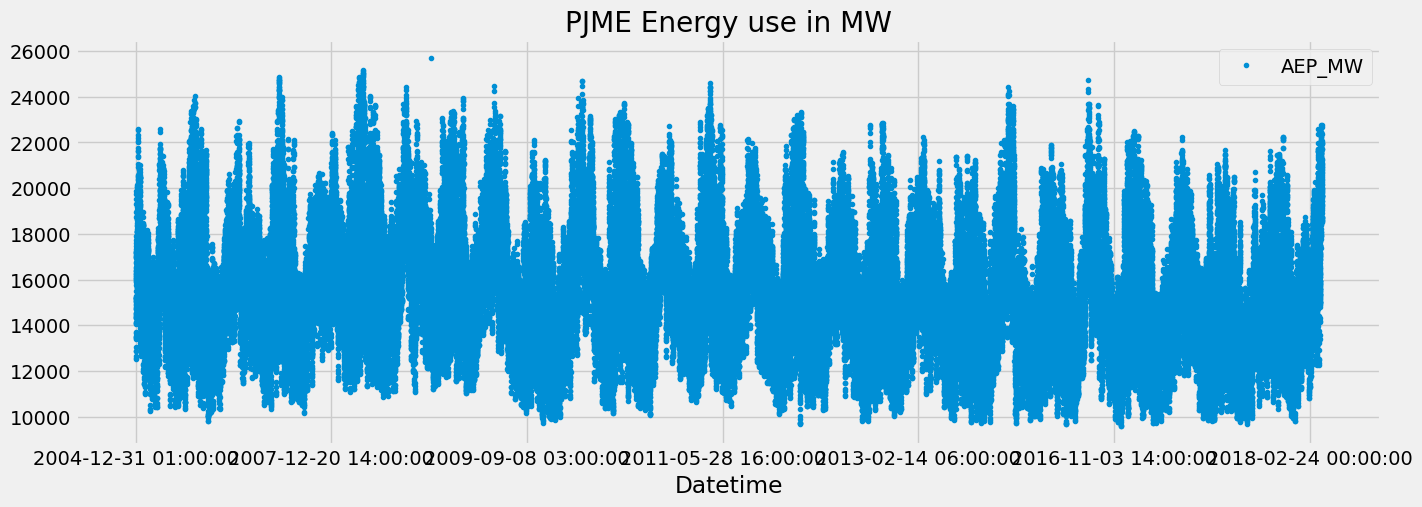

In [84]:
df.plot(style='.',figsize=(15,5),color=color_pal[0],title='PJME Energy use in MW')

In [85]:
df.index=pd.to_datetime(df.index) 

Train/Test split

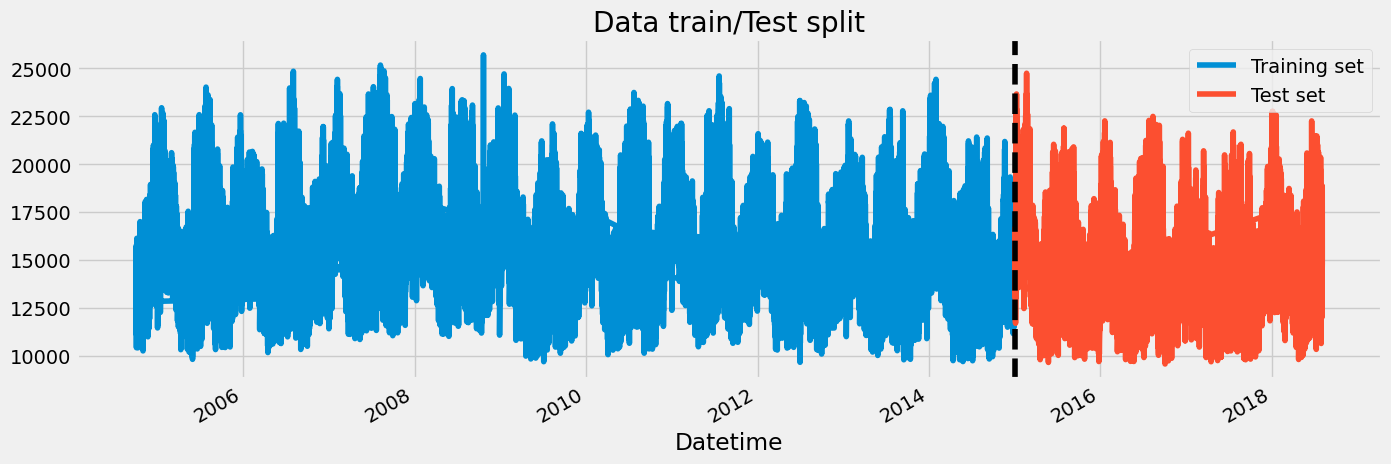

In [86]:
train=df.loc[df.index < '01-01-2015']
test=df.loc[df.index >= '01-01-2015']

fig,ax=plt.subplots(figsize=(15,5))
train.plot(ax=ax,label='Training set',title='Data train/Test split')
test.plot(ax=ax,label='Test set')
ax.axvline('01-01-2015',color='black',ls='--')
ax.legend(['Training set','Test set'])
plt.show()

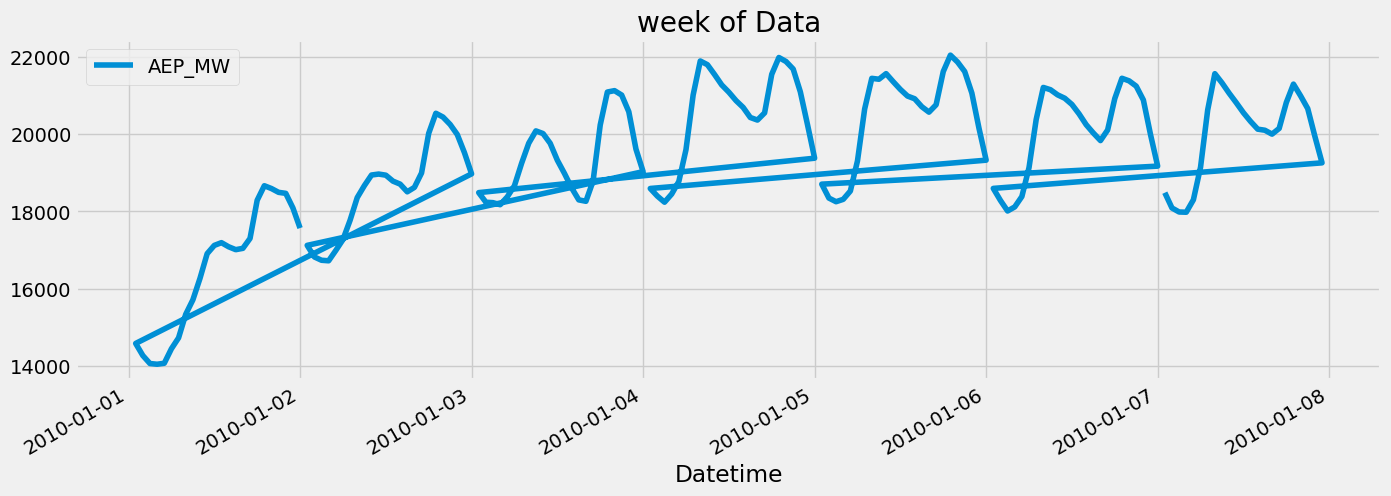

In [87]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5),title='week of Data')
plt.show()

#Feature Creation

In [88]:
def create_feature(df):
    '''create time series feature based on timeseries index'''
    df=df.copy()
    df['hour']=df.index.hour
    df['dayofweek']=df.index.day_of_week
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofyear']=df.index.day_of_year
    return df

df=create_feature(df)

Visualize our Feature/Target Relationship 

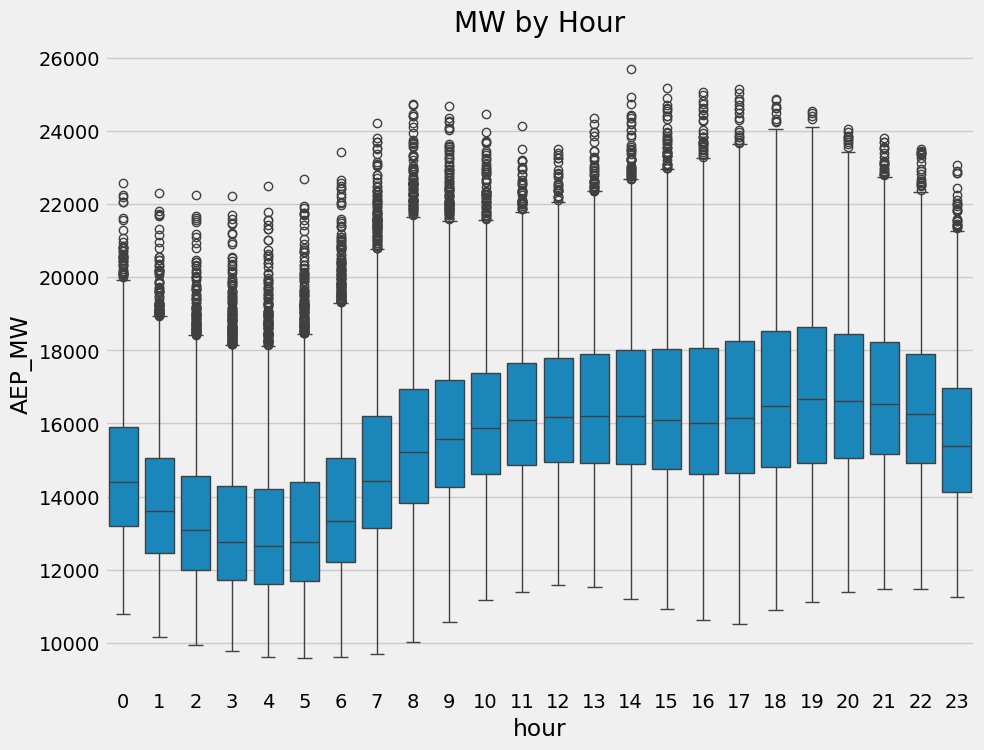

In [89]:
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='hour',y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

C:\Users\akashsingh\AppData\Local\Temp\ipykernel_1144\1700213130.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x='month',y='AEP_MW',palette='Blues')


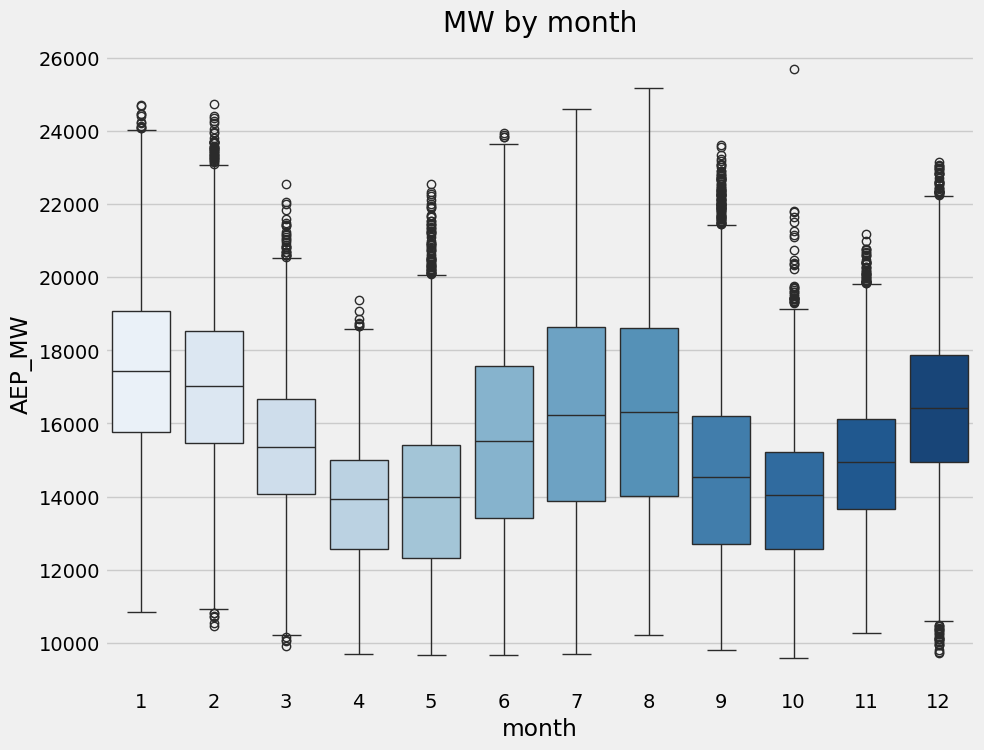

In [90]:
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='month',y='AEP_MW',palette='Blues')
ax.set_title('MW by month')
plt.show()

Create Our Model

In [91]:
train=create_feature(train)
test=create_feature(test)

In [92]:
FEATURES=['hour', 'dayofweek', 'month', 'year', 'dayofyear']
TARGET='AEP_MW'


X_train=train[FEATURES]
y_train=train[TARGET]

X_test=test[FEATURES]
y_test=test[TARGET]

In [93]:
reg=xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,
                     learning_rate=0.01)
reg.fit(X_train,y_train,
        eval_set=[(X_train,y_train),(X_test,y_test)],
        verbose=100)

[0]	validation_0-rmse:2557.05852	validation_1-rmse:2669.66874
[100]	validation_0-rmse:1667.99304	validation_1-rmse:1906.43321
[200]	validation_0-rmse:1388.41609	validation_1-rmse:1728.03964
[300]	validation_0-rmse:1260.06288	validation_1-rmse:1670.93868
[400]	validation_0-rmse:1170.54347	validation_1-rmse:1651.83339
[500]	validation_0-rmse:1113.48343	validation_1-rmse:1644.49126
[545]	validation_0-rmse:1091.20163	validation_1-rmse:1647.88201


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [94]:
joblib.dump(reg,'reg.pkl')

['reg.pkl']

Feature Importance

In [95]:
fi=pd.DataFrame(data=reg.feature_importances_,
                index=reg.feature_names_in_,
                columns=['importance'])
fi

,importance
hour,0.451918
dayofweek,0.190400
month,0.145771
year,0.060682
dayofyear,0.151228


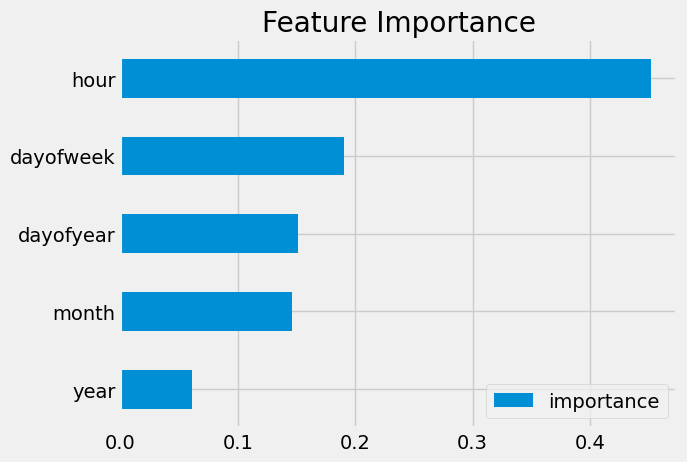

In [96]:
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()

In [97]:
test['prediction']=reg.predict(X_test)

In [98]:
df=df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

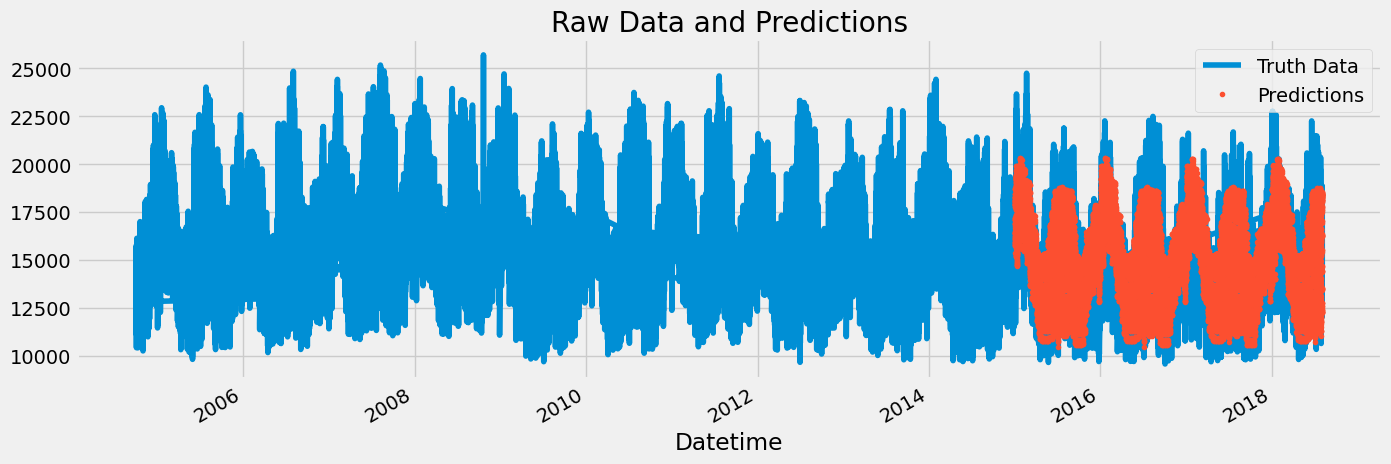

In [99]:
ax=df[['AEP_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax,style='.')
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()


In [100]:
score=np.sqrt(mean_squared_error(test['AEP_MW'],test['prediction']))
print(f'RMSE root square on Test Set: {score:0.2f}')

RMSE root square on Test Set: 1644.39


#

#Calculate Error
-Look at the worst and best predicted days

In [101]:
test['error']=np.abs(test[TARGET]-test['prediction'])

In [102]:
test['date']=test.index.date

In [103]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2017-01-22    4872.108968
2015-02-20    4861.401571
2015-02-19    4769.359985
2018-01-06    4403.549683
2017-02-07    4290.881022
Name: error, dtype: float64

KNN


In [104]:
#2.use knn reg and build the model an choose the data of your domain and choice

In [105]:
from sklearn.neighbors import KNeighborsRegressor

In [106]:
cars_data=pd.read_csv('Automobile.csv')

In [107]:
cars_data.head(5)

,name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,70,usa
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,70,usa
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,70,usa
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,70,usa
4,ford torino,17.0,8,302.0,140.0,3449,10.5,70,usa


In [108]:
# The index is already set to 'name', so just display the index
cars_data.set_index('name',inplace=True)

In [109]:
cars_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, chevrolet chevelle malibu to chevy s-10
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 28.0+ KB


In [110]:
cars_data.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

In [111]:
cars_data.shape

(398, 8)

In [112]:
cars_data.drop('origin',axis=1,inplace=True)

In [113]:
cars_data.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


In [114]:
cars_data.groupby('cylinders').count()

,mpg,displacement,horsepower,weight,acceleration,model_year
cylinders,,,,,,
3,4,4,4,4,4,4
4,204,204,199,204,204,204
5,3,3,3,3,3,3
6,84,84,83,84,84,84
8,103,103,103,103,103,103


In [115]:
cars_data=cars_data[cars_data.cylinders==4]
cars_data.drop('cylinders',axis=1)
cars_data.head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
name,,,,,,,
toyota corona mark ii,24.0,4,113.0,95.0,2372,15.0,70
datsun pl510,27.0,4,97.0,88.0,2130,14.5,70
volkswagen 1131 deluxe sedan,26.0,4,97.0,46.0,1835,20.5,70
peugeot 504,25.0,4,110.0,87.0,2672,17.5,70
audi 100 ls,24.0,4,107.0,90.0,2430,14.5,70
saab 99e,25.0,4,104.0,95.0,2375,17.5,70
bmw 2002,26.0,4,121.0,113.0,2234,12.5,70
datsun pl510,27.0,4,97.0,88.0,2130,14.5,71
chevrolet vega 2300,28.0,4,140.0,90.0,2264,15.5,71


In [116]:
cars_data.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
mpg,1.000000,NaN,-0.497669,-0.591491,-0.543077,0.074885,0.547689
cylinders,NaN,NaN,NaN,NaN,NaN,NaN,NaN
displacement,-0.497669,NaN,1.000000,0.645389,0.824000,-0.173578,0.155972
horsepower,-0.591491,NaN,0.645389,1.000000,0.665047,-0.486718,-0.154520
weight,-0.543077,NaN,0.824000,0.665047,1.000000,0.026116,0.120711
acceleration,0.074885,NaN,-0.173578,-0.486718,0.026116,1.000000,-0.009874
model_year,0.547689,NaN,0.155972,-0.154520,0.120711,-0.009874,1.000000


In [117]:
cars_data['horsepower'].isnull().sum()

np.int64(5)

In [118]:
median_horsepower = cars_data['horsepower'].median()
cars_data['horsepower'].fillna(median_horsepower, inplace=True)

C:\Users\akashsingh\AppData\Local\Temp\ipykernel_1144\2619165964.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cars_data['horsepower'].fillna(median_horsepower, inplace=True)


In [119]:
knn_regression_data = cars_data.loc[:,["horsepower","weight", "mpg","displacement"]]
knn_regression_data.head() 

,horsepower,weight,mpg,displacement
name,,,,
toyota corona mark ii,95.0,2372,24.0,113.0
datsun pl510,88.0,2130,27.0,97.0
volkswagen 1131 deluxe sedan,46.0,1835,26.0,97.0
peugeot 504,87.0,2672,25.0,110.0
audi 100 ls,90.0,2430,24.0,107.0


In [120]:
knn_regression_data = (knn_regression_data - np.min(knn_regression_data))/(np.max(knn_regression_data) - np.min(knn_regression_data))
knn_regression_data.describe().T

,count,mean,std,min,25%,50%,75%,max
horsepower,204.0,0.018535,0.004411,0.008610,0.015375,0.018450,0.021525,0.029828
weight,204.0,0.704221,0.106732,0.490467,0.623539,0.680812,0.783748,1.000000
mpg,204.0,0.003471,0.001756,0.000000,0.002153,0.003152,0.004613,0.008795
displacement,204.0,0.028228,0.006615,0.015375,0.022448,0.026753,0.031750,0.042435


In [121]:
knn_regression_data.dtypes

horsepower      float64
weight          float64
mpg             float64
displacement    float64
dtype: object

In [122]:
knn_independent=knn_regression_data.drop('displacement',axis=1)
knn_dependent=knn_regression_data['displacement']

In [123]:
from sklearn.model_selection import train_test_split

independent_train, independent_test, dependent_train, dependent_test = train_test_split(
    knn_independent, 
    knn_dependent, 
    test_size = 0.10, 
    random_state = 20)
independent_train.isnull().sum()

horsepower    0
weight        0
mpg           0
dtype: int64

In [124]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor().fit(independent_train, dependent_train)
predicted_values = knn_model.predict(independent_test)

In [125]:
predict_df = pd.DataFrame({"Dependent_Test" : dependent_test, "Dependent_Predicted" : predicted_values})
predict_df.head()

,Dependent_Test,Dependent_Predicted
name,,
saab 99e,0.026445,0.031304
saab 99le,0.031673,0.033702
honda prelude,0.027368,0.026199
buick skylark limited,0.040898,0.033887
vw pickup,0.024293,0.024539


In [126]:
predict_df = (predict_df*(np.max(cars_data.displacement) - np.min(cars_data.displacement))) + np.min(cars_data.displacement)
predict_df.head()

,Dependent_Test,Dependent_Predicted
name,,
saab 99e,70.327183,70.754736
saab 99le,70.787208,70.965806
honda prelude,70.408364,70.305535
buick skylark limited,71.599016,70.982042
vw pickup,70.137761,70.159410


In [127]:
print("Mean Squared Error = ", mean_squared_error(predict_df.Dependent_Predicted, predict_df.Dependent_Test))
print("Root Mean Squared Error = ", np.sqrt(mean_squared_error(predict_df.Dependent_Predicted, predict_df.Dependent_Test)))

Mean Squared Error =  0.1034122989270653
Root Mean Squared Error =  0.3215778271695132


In [128]:
r2_score( predict_df.Dependent_Test,predict_df.Dependent_Predicted)

0.6713021311631161

In [129]:
joblib.dump(knn_model,'knn_model.pkl')

['knn_model.pkl']

In [130]:
from sklearn.model_selection import GridSearchCV
knn_params = {"n_neighbors" : np.arange(1,11,1)}
knn = KNeighborsRegressor()
knn_cv_model = GridSearchCV(knn, knn_params, cv = 10)
knn_cv_model.fit(independent_train, dependent_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [131]:
knn_cv_model.best_params_["n_neighbors"]

np.int64(10)

In [132]:
knn_10=KNeighborsRegressor(n_neighbors=10)
knn_10.fit(independent_train, dependent_train)

KNeighborsRegressor(n_neighbors=10)

In [133]:
pred= knn_10.predict(independent_test)

In [134]:
r2_score(dependent_test, knn_10.predict(independent_test))

0.6817938740935432

In [135]:
df1=pd.DataFrame({'dependent_test':dependent_test,'dependent_predicted':pred})

In [136]:
predict_df1 = (df1*(np.max(cars_data.displacement) - np.min(cars_data.displacement))) + np.min(cars_data.displacement)
predict_df1.head()

,dependent_test,dependent_predicted
name,,
saab 99e,70.327183,70.722263
saab 99le,70.787208,71.087577
honda prelude,70.408364,70.365068
buick skylark limited,71.599016,71.028044
vw pickup,70.137761,70.091759


In [137]:
print("Mean Squared Error = ", mean_squared_error(df1.dependent_predicted, df1.dependent_test))
print("Root Mean Squared Error = ", np.sqrt(mean_squared_error(df1.dependent_predicted, df1.dependent_test)))

Mean Squared Error =  1.2927617580076695e-05
Root Mean Squared Error =  0.003595499628713191


In [138]:
joblib.dump(knn_10,'knn_10.pkl')

['knn_10.pkl']

In [139]:
@st.cache_resource
def load_data():
    try:
        models={
            'xgreg':joblib.load('reg.pkl'),
            'knnreg':joblib.load('knn_model.pkl')    
        }
        df = pd.read_csv(r"F:\study material\data science\euroncourse\.venv\xgboost_knn\AEP_hourly.csv")
        cars_data=pd.read_csv('Automobile.csv')
        return models,df,cars_data

    except FileNotFoundError:
        st.error("Model or scaler files not found. Please run the `svm.ipynb` script first.")
        st.stop()  
        
models,df,cars_data=load_data()

NameError: name 'st' is not defined